In [2]:
# Librairies
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


 
# image
from PIL import Image
import io
from io import StringIO
from skimage.io import imread, imshow

import cv2

# S3 AWS
import boto3
import configparser

# Spark
import findspark  #Findspark : Make Spark available in Jupyter notebook
findspark.init('/home/ubuntu/spark-3.3.0-bin-hadoop3')

# Pyspark.
import pyspark
from pyspark.sql import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import * 
from pyspark.sql.functions import input_file_name, udf, col, pandas_udf, PandasUDFType, split
from pyspark.sql.types import ArrayType, StringType, IntegerType, DoubleType, DataType, FloatType
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.ml.feature import StandardScaler, PCA


# Tensorflow
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings('ignore')

2022-10-16 13:10:59.706178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# We need the aws credentials in order to be able to access the s3 bucket. 
# We can use the configparser package to read the credentials from the standard aws file.

config = configparser.ConfigParser()
config.read(os.path.expanduser("~/.aws/credentials"))
aws_credentials = 'default'
AWS_ACCESS_KEY_ID = config.get(aws_credentials, "aws_access_key_id") 
AWS_SECRET_ACCESS_KEY = config.get(aws_credentials, "aws_secret_access_key")

In [6]:
config = configparser.ConfigParser()
config.read(os.path.expanduser("~/.aws/config"))
aws_config = 'default'
RGION_NAME = config.get(aws_config, "region") 

In [7]:
# Retrieve the list of existing buckets
session = boto3.session.Session(aws_access_key_id=AWS_ACCESS_KEY_ID, 
                                aws_secret_access_key=AWS_SECRET_ACCESS_KEY)
s3_client = session.client(service_name='s3', region_name= RGION_NAME)

# Output the bucket names
response = s3_client.list_buckets()

# Output the bucket names
print('Existing buckets:')
for bucket in response['Buckets']:
    print(f'  {bucket["Name"]}')
BUCKET_NAME = response['Buckets'][0]["Name"]

Existing buckets:
  ocr-projet8-fruits


In [8]:
# Configuration chemins S3
DATASET_PATH = 's3a://' + BUCKET_NAME + '/'
DIR_PATH = 'Training/'
DATASET_PATH

's3a://ocr-projet8-fruits/'

In [9]:
path_folders = []
result = s3_client.list_objects(Bucket=BUCKET_NAME, Prefix=DIR_PATH, Delimiter='/')
for o in result.get('CommonPrefixes'):
    #print ('sub folder : ', o.get('Prefix'))
    l= DATASET_PATH + o.get('Prefix') + '*'
    path_folders.append(l)
path_folders

['s3a://ocr-projet8-fruits/Training/apple_6/*',
 's3a://ocr-projet8-fruits/Training/apple_braeburn_1/*',
 's3a://ocr-projet8-fruits/Training/apple_crimson_snow_1/*',
 's3a://ocr-projet8-fruits/Training/apple_golden_1/*',
 's3a://ocr-projet8-fruits/Training/apple_golden_2/*',
 's3a://ocr-projet8-fruits/Training/apple_golden_3/*',
 's3a://ocr-projet8-fruits/Training/apple_granny_smith_1/*',
 's3a://ocr-projet8-fruits/Training/apple_hit_1/*',
 's3a://ocr-projet8-fruits/Training/apple_pink_lady_1/*',
 's3a://ocr-projet8-fruits/Training/apple_red_1/*',
 's3a://ocr-projet8-fruits/Training/apple_red_2/*',
 's3a://ocr-projet8-fruits/Training/apple_red_3/*',
 's3a://ocr-projet8-fruits/Training/apple_red_delicios_1/*',
 's3a://ocr-projet8-fruits/Training/apple_red_yellow_1/*',
 's3a://ocr-projet8-fruits/Training/apple_rotten_1/*',
 's3a://ocr-projet8-fruits/Training/cabbage_white_1/*',
 's3a://ocr-projet8-fruits/Training/carrot_1/*',
 's3a://ocr-projet8-fruits/Training/cucumber_1/*',
 's3a://ocr

### Enable access to s3 data from Spark

In order to be able to read data via S3A we need a couple of dependencies / 
we need to make sure the hadoop-aws and aws-java-sdk packages are available when we load spark:

In [10]:
# Add an environnement variable
os.environ['PYSPARK_SUBMIT_ARGS'] = "--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:3.3.1 pyspark-shell"

In [11]:
spark = (SparkSession
             .builder.master('local[*]')
             .appName('p8-fruits')
             .config('spark.hadoop.fs.s3a.access.key', AWS_ACCESS_KEY_ID)
             .config('spark.hadoop.fs.s3a.secret.key', AWS_SECRET_ACCESS_KEY) 
             .config('spark.hadoop.fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem') 
             .getOrCreate()
            )
sc = SparkContext.getOrCreate()
sc.setSystemProperty('com.amazonaws.services.s3.enableV4', 'true')
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3.eu-west-3.amazonaws.com")
sc.setLogLevel('WARN')
spark

:: loading settings :: url = jar:file:/home/ubuntu/spark-3.3.0-bin-hadoop3/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
com.amazonaws#aws-java-sdk-pom added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a5226a2e-94b4-45c5-9c88-8018ecd3721d;1.0
	confs: [default]
	found com.amazonaws#aws-java-sdk-pom;1.10.34 in central
	found org.apache.hadoop#hadoop-aws;3.3.1 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.901 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
downloading https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/3.3.1/hadoop-aws-3.3.1.jar ...
	[SUCCESSFUL ] org.apache.hadoop#hadoop-aws;3.3.1!hadoop-aws.jar (79ms)
downloading https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-bundle/1.11.901/aws-java-sdk-bundle-1.11.901.jar ...
	[SUCCESSFUL ] com.amazonaws#aws-java-sdk-bundle;1.11.901!aws-java-sdk-bundle.jar (1537ms)
downloading https://repo1.maven.o

22/10/16 13:17:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [12]:
zipped = zip(path_folders)
columns = ['path_folders']

df_images = spark.createDataFrame(zipped, columns)
df_images.show()

+--------------------+
|        path_folders|
+--------------------+
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
|s3a://ocr-projet8...|
+--------------------+
only showing top 20 rows



In [13]:
df_images.collect()[0][0]

's3a://ocr-projet8-fruits/Training/apple_6/*'

In [14]:
df_images.count()

24

## Extraction liste d'images

Load Data par la création du RDD des images en mode binaryfile avec le path de chaque image

In [15]:
#initiation phase first row (row = 0)
path_initiation = df_images.collect()[0][0]
images = spark.read.format("binaryfile").load(path_initiation)
#loop for to collect all photos
for row in range(1, df_images.count()):
    path_i = df_images.collect()[row][0]
    img_i = spark.read.format("binaryfile").load(path_i)
    images = images.union(img_i)


images.printSchema()

22/10/16 13:17:46 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [16]:
print((images.count(), len(images.columns)))

(6231, 4)


In [17]:
img_df = images.select("path", "content")
img_df = img_df.withColumn("target", split(col("path"), "/").getItem(4))
img_df.show()

+--------------------+--------------------+-------+
|                path|             content| target|
+--------------------+--------------------+-------+
|s3a://ocr-projet8...|[FF D8 FF E0 00 1...|apple_6|
|s3a://ocr-projet8...|[FF D8 FF E0 00 1...|apple_6|
|s3a://ocr-projet8...|[FF D8 FF E0 00 1...|apple_6|
|s3a://ocr-projet8...|[FF D8 FF E0 00 1...|apple_6|
|s3a://ocr-projet8...|[FF D8 FF E0 00 1...|apple_6|
|s3a://ocr-projet8...|[FF D8 FF E0 00 1...|apple_6|
|s3a://ocr-projet8...|[FF D8 FF E0 00 1...|apple_6|
|s3a://ocr-projet8...|[FF D8 FF E0 00 1...|apple_6|
|s3a://ocr-projet8...|[FF D8 FF E0 00 1...|apple_6|
|s3a://ocr-projet8...|[FF D8 FF E0 00 1...|apple_6|
|s3a://ocr-projet8...|[FF D8 FF E0 00 1...|apple_6|
|s3a://ocr-projet8...|[FF D8 FF E0 00 1...|apple_6|
|s3a://ocr-projet8...|[FF D8 FF E0 00 1...|apple_6|
|s3a://ocr-projet8...|[FF D8 FF E0 00 1...|apple_6|
|s3a://ocr-projet8...|[FF D8 FF E0 00 1...|apple_6|
|s3a://ocr-projet8...|[FF D8 FF E0 00 1...|apple_6|
|s3a://ocr-p

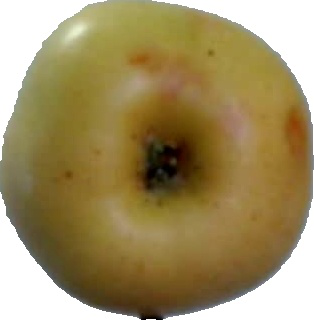

In [18]:
# Take first image of dataset
img_example = img_df.collect()[0]["content"]
# Convert from bytes to jpeg using tensorflow
img_example = load_img(io.BytesIO(img_example))

img_example

In [19]:
def resize_sq_fill_image(img, sq_size=224, fill_col=(255,255,255),
                 interpolation=Image.ANTIALIAS):
    '''
    this function takes an image, resizes the image and fills the non existing space
    with custom color

    Argumants:
        img: image in np or PIL format    
        sq_size: size request    
        fill_col: fill color request
    
    returns:
        new_img: image resized with fill color
    '''    
    w, h = img.size
    if h != w:
        dif = h if h > w else w
        new_img = Image.new('RGB', (dif, dif), fill_col)
        new_img.paste(img, (int((dif - w) / 2), int((dif - h) / 2)))
        img = new_img
    
    # Change format to np.array and resize with cv2
    new_img = cv2.resize(np.asarray(img), (sq_size, sq_size), interpolation)
    return np.array(new_img)

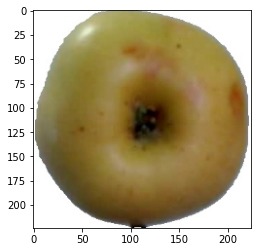

In [20]:
img_resize = resize_sq_fill_image(img_example)
plt.imshow(img_resize)

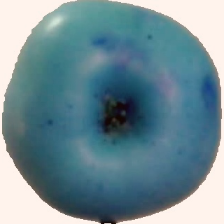

In [21]:
img_process = preprocess_input(img_resize)
array_to_img(img_process)

## CNN Transfert Learnning - Features Extraction
### model preparation

In [22]:
# model without top layers
model_vgg16 = VGG16(weights="imagenet", 
                    include_top=False,
                    pooling='max', 
                    input_shape=(224, 224, 3))

model_vgg16.summary() 

2022-10-16 13:19:36.635024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [23]:
# Sérialise le modèle pour une execution plus rapide
sc = spark.sparkContext
model_bc = sc.broadcast(model_vgg16)

INFO:tensorflow:Assets written to: ram://4bc9c18b-6994-406f-a864-c0c492731181/assets


INFO:tensorflow:Assets written to: ram://4bc9c18b-6994-406f-a864-c0c492731181/assets


In [24]:
def extract(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = load_img(io.BytesIO(content), target_size=(224, 224, 3)) #open the binaries data image and resized
    
    arr = img_to_array(img) #image to array

    arr = np.expand_dims(arr, axis=0)
    proc = preprocess_input(arr) # Preprocessing pour les besoins du modèle (soustraction de la moyenne RGB du modèle d'entrainement)
    features = model_bc.value.predict(proc,verbose=0) # .value car modèle sérialisé
    vector_feature = Vectors.dense(features.ravel().tolist())    
    return vector_feature

In [25]:
extract_features = udf(lambda x: extract(x), VectorUDT()) # UDF est la fonction spark de apply

img_df = img_df.withColumn('vgg16vec', extract_features('content')).select('path', 'target', 'content', 'vgg16vec') 
img_df.show()
img_df.persist() # Pour le conserver en mémoire

2022-10-16 13:19:43.783306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-16 13:19:47.457688: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


+--------------------+-------+--------------------+--------------------+
|                path| target|             content|            vgg16vec|
+--------------------+-------+--------------------+--------------------+
|s3a://ocr-projet8...|apple_6|[FF D8 FF E0 00 1...|[30.2016582489013...|
|s3a://ocr-projet8...|apple_6|[FF D8 FF E0 00 1...|[26.2421035766601...|
|s3a://ocr-projet8...|apple_6|[FF D8 FF E0 00 1...|[19.0790557861328...|
|s3a://ocr-projet8...|apple_6|[FF D8 FF E0 00 1...|[19.8468227386474...|
|s3a://ocr-projet8...|apple_6|[FF D8 FF E0 00 1...|[41.1322822570800...|
|s3a://ocr-projet8...|apple_6|[FF D8 FF E0 00 1...|[20.8566417694091...|
|s3a://ocr-projet8...|apple_6|[FF D8 FF E0 00 1...|[21.2901153564453...|
|s3a://ocr-projet8...|apple_6|[FF D8 FF E0 00 1...|[18.4541912078857...|
|s3a://ocr-projet8...|apple_6|[FF D8 FF E0 00 1...|[36.2096748352050...|
|s3a://ocr-projet8...|apple_6|[FF D8 FF E0 00 1...|[33.4132766723632...|
|s3a://ocr-projet8...|apple_6|[FF D8 FF E0 00 1...|

DataFrame[path: string, target: string, content: binary, vgg16vec: vector]

In [26]:
# Standardisation des données
standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='vgg16vec',
                              outputCol='features_scaled')
std = standardizer.fit(img_df)
img_df_std = std.transform(img_df)
img_df_std = img_df_std.select('path', 'target', 'vgg16vec', 'features_scaled')

2022-10-16 13:19:56.522597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-16 13:19:56.552269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-16 13:19:56.572859: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

In [27]:
img_df_std.show()

+--------------------+-------+--------------------+--------------------+
|                path| target|            vgg16vec|     features_scaled|
+--------------------+-------+--------------------+--------------------+
|s3a://ocr-projet8...|apple_6|[30.2016582489013...|[-0.5761468591671...|
|s3a://ocr-projet8...|apple_6|[26.2421035766601...|[-0.7445760838656...|
|s3a://ocr-projet8...|apple_6|[19.0790557861328...|[-1.0492736283383...|
|s3a://ocr-projet8...|apple_6|[19.8468227386474...|[-1.0166148060047...|
|s3a://ocr-projet8...|apple_6|[41.1322822570800...|[-0.1111863574026...|
|s3a://ocr-projet8...|apple_6|[20.8566417694091...|[-0.9736597136986...|
|s3a://ocr-projet8...|apple_6|[21.2901153564453...|[-0.9552208673547...|
|s3a://ocr-projet8...|apple_6|[18.4541912078857...|[-1.0758537529149...|
|s3a://ocr-projet8...|apple_6|[36.2096748352050...|[-0.3205813576470...|
|s3a://ocr-projet8...|apple_6|[33.4132766723632...|[-0.4395329099057...|
|s3a://ocr-projet8...|apple_6|[35.4048233032226...|

In [28]:
pca = PCA(k=512, inputCol="features_scaled", outputCol="Features_PCA")
pca_model = pca.fit(img_df_std)

result = pca_model.transform(img_df_std).select('path', 'target', "Features_PCA")

result.show()

22/10/16 13:28:02 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/16 13:28:02 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/10/16 13:28:04 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/10/16 13:28:04 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
22/10/16 13:28:05 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
+--------------------+-------+--------------------+
|                path| target|        Features_PCA|
+--------------------+-------+--------------------+
|s3a://ocr-projet8...|apple_6|[6.02167049827658...|
|s3a://ocr-projet8...|apple_6|[6.33455203924989...|
|s3a://ocr-projet8...|apple_6|[6.33422820826141...|
|s3a://ocr-projet8...|apple_6|[5.63217905653392...|
|s3a://ocr-projet8...|apple_6|[7.33083292581700...|
|s3a://ocr-projet8...|apple_6|[6.46447239122254...|
|s3a://ocr-projet8...|apple_6|[5.24575084518347...|
|s3a://ocr-projet8...|apple_6|[6.50436244548909...|
|s3a://ocr-projet8...|apple_6|[6.83885031678862...|
|s3a://ocr-projet8...|apple_6|[6.11204771003936...|
|s3a://ocr-projet8.

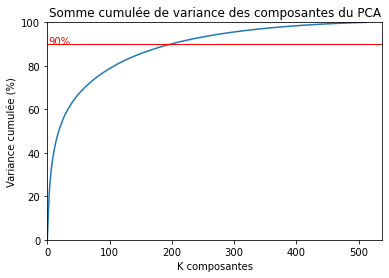

In [32]:
import seaborn as sns

# Calcul du % de variance expliqué par la PCA
var = pca_model.explainedVariance.cumsum()
sns.lineplot(x=[i for i in range(512+1)], 
             y=np.insert(var, 0, 0)*100)
plt.title('Somme cumulée de variance des composantes du PCA')
plt.xlabel('K composantes')
plt.ylabel('Variance cumulée (%)')
plt.ylim(0, 100)
plt.xlim(left=0)
plt.axhline(90, lw=1, c='red')
plt.text(1, 90, '90%', c='red')
plt.show()

In [29]:
#coalesce : définit le nombre de fichier csv différents à créer. coalesce(1) signifie créer un seul csv contenant toutes les images (1 gros fichier)
result.withColumn("Features_PCA", col("Features_PCA").cast("string")).coalesce(1).write.option("header","true").mode("Overwrite").csv(path="s3a://ocr-projet8-fruits/Result_Features_PCA") 


22/10/16 13:28:06 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.
22/10/16 13:28:06 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/10/16 13:28:06 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


In [30]:
path="s3a://ocr-projet8-fruits/Result_Features_PCA"

df = spark.read.format("csv").option("header","true").option("recursiveFileLookup", "true").load(path)
df_csv = df.toPandas()
df_csv

,path,target,Features_PCA
0,s3a://ocr-projet8-fruits/Training/apple_6/r1_2...,apple_6,"[6.0216704982765865,0.399038167937442,-1.81991..."
1,s3a://ocr-projet8-fruits/Training/apple_6/r1_2...,apple_6,"[6.334552039249898,-0.5893377444415362,-2.0189..."
2,s3a://ocr-projet8-fruits/Training/apple_6/r1_2...,apple_6,"[6.334228208261411,-1.1025477186085009,-1.5673..."
3,s3a://ocr-projet8-fruits/Training/apple_6/r1_2...,apple_6,"[5.6321790565339205,-0.4874980102014573,-0.775..."
4,s3a://ocr-projet8-fruits/Training/apple_6/r1_3...,apple_6,"[7.330832925817006,1.5993639551299204,-3.14191..."
...,...,...,...
6226,s3a://ocr-projet8-fruits/Training/zucchini_dar...,zucchini_dark_1,"[-11.241049560166484,8.63612900725817,-7.65594..."
6227,s3a://ocr-projet8-fruits/Training/zucchini_dar...,zucchini_dark_1,"[-10.716833398687523,6.795753402661164,-5.2283..."
6228,s3a://ocr-projet8-fruits/Training/zucchini_dar...,zucchini_dark_1,"[-11.097233955419231,5.613740483334134,-7.2736..."
6229,s3a://ocr-projet8-fruits/Training/zucchini_dar...,zucchini_dark_1,"[-10.574428327918048,7.529459286680587,-5.5685..."
